Бизнес-задача: Прогнозирование оттока клиентов (Customer Churn Prediction)
Описание задачи:

Компании, предоставляющие услуги по подписке (например, интернет-провайдеры, мобильные операторы, стриминговые сервисы), часто сталкиваются с проблемой оттока клиентов. Задача состоит в том, чтобы предсказать, какие клиенты, скорее всего, прекратят пользоваться услугами компании в ближайшем будущем. Это позволяет компании своевременно принять меры для удержания этих клиентов, предложив им, например, скидки или улучшенные условия.
Задача машинного обучения:

Необходимо построить модель машинного обучения, которая будет предсказывать, какие клиенты с высокой вероятностью могут прекратить пользоваться услугами компании в ближайшем будущем.
Датасет:

Для данной задачи хорошо подходит датасет Telco Customer Churn, который содержит информацию о клиентах телекоммуникационной компании. Датасет включает демографические данные, информацию об услугах, которыми пользуется клиент, и факт оттока.

Ссылка на датасет: Telco Customer Churn

# Первичный анализ и предобработка

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("Первые несколько строк датасета:")
print(df.head())

print("\nОбщая информация о датасете:")
print(df.info())

print("\nСтатистический обзор числовых данных:")
print(df.describe())

print("\nПроверка на наличие пропущенных значений:")
print(df.isnull().sum())

df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

scaler = StandardScaler()
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("\nПервые несколько строк обработанного датасета:")
print(df.head())


Первые несколько строк датасета:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Str

C:\Users\nsedoff\AppData\Local\Temp\ipykernel_10360\4169767128.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


# EDA

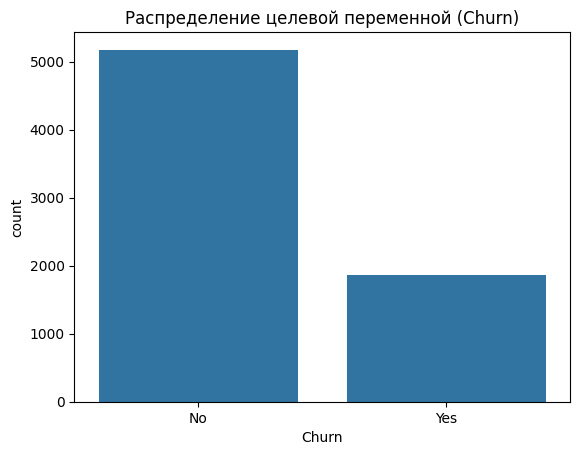

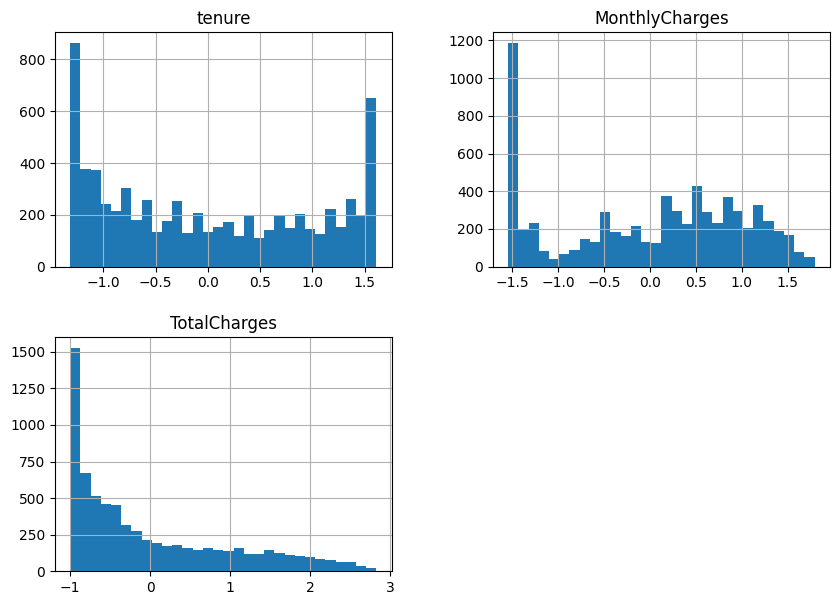

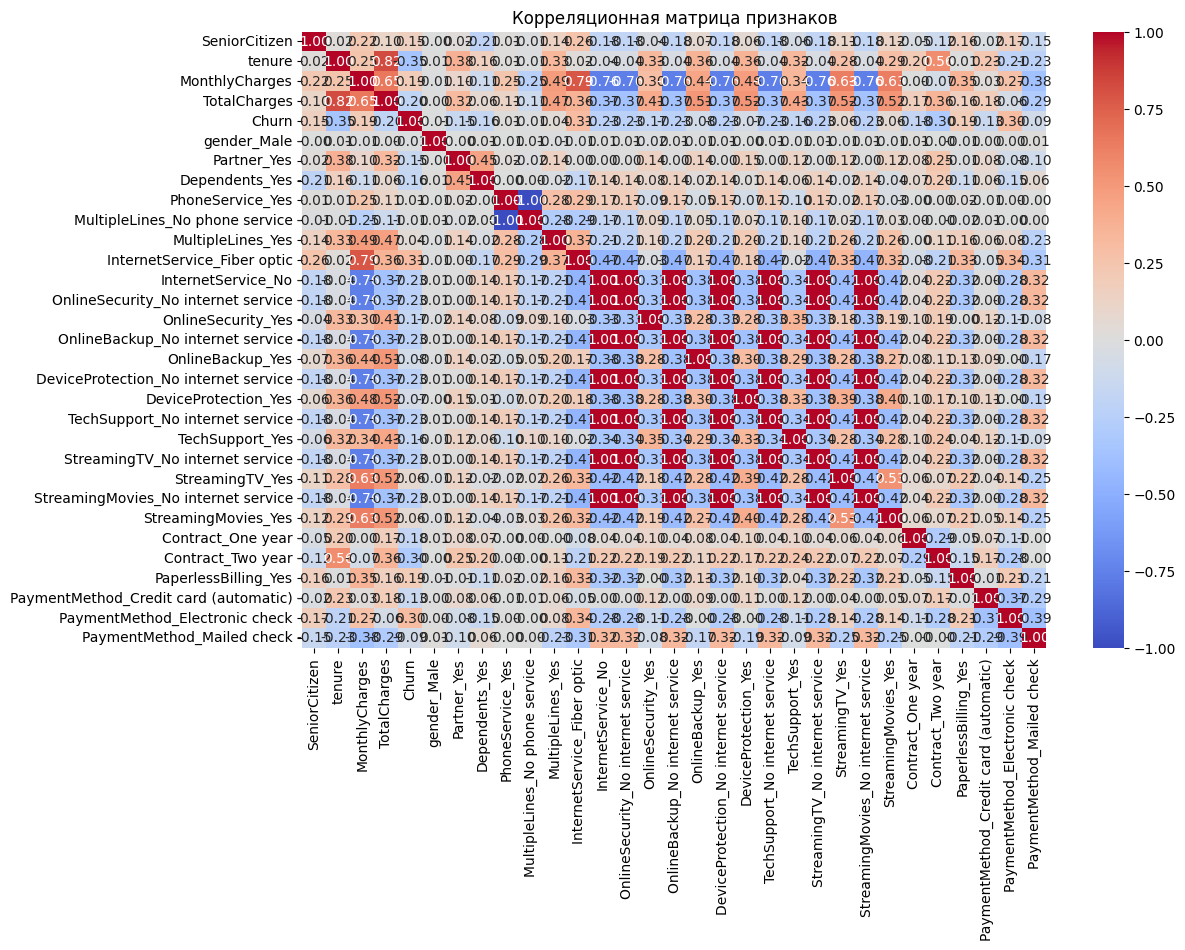

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Распределение целевой переменной (Churn)
sns.countplot(x='Churn', data=df)
plt.title('Распределение целевой переменной (Churn)')
plt.show()

# Распределение числовых признаков
df[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(bins=30, figsize=(10, 7))
plt.show()

# Удалим строковые столбцы перед построением корреляционной матрицы
# Кроме того, преобразуем 'Churn' в числовой формат
df_for_corr = df.drop(columns=['customerID'])
df_for_corr['Churn'] = df_for_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Корреляционная матрица
plt.figure(figsize=(12, 8))
sns.heatmap(df_for_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()


In [4]:
# Создание нового признака "NewCustomer"
df['NewCustomer'] = df['tenure'].apply(lambda x: 1 if x < 12 else 0)

# Убедимся, что новый признак создан
print(df[['tenure', 'NewCustomer']].head())


     tenure  NewCustomer
0 -1.277445            1
1  0.066327            1
2 -1.236724            1
3  0.514251            1
4 -1.236724            1


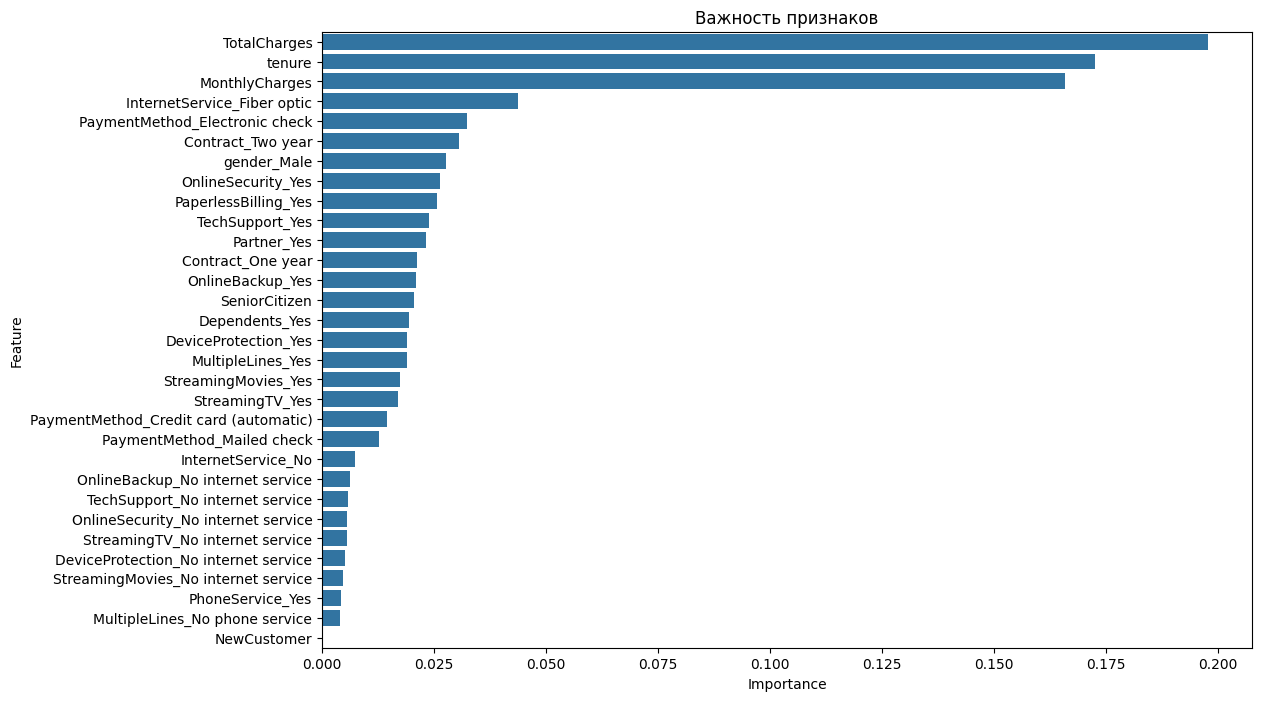

Топ-10 отобранных признаков: ['TotalCharges' 'tenure' 'MonthlyCharges' 'InternetService_Fiber optic'
 'PaymentMethod_Electronic check' 'Contract_Two year' 'gender_Male'
 'OnlineSecurity_Yes' 'PaperlessBilling_Yes' 'TechSupport_Yes']


In [5]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Определим целевую переменную и признаки
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Обучение модели Random Forest для оценки важности признаков
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Оценка важности признаков
importances = model.feature_importances_

# Создание DataFrame для визуализации важности признаков
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков')
plt.show()

# Выбор топ-10 наиболее значимых признаков
selected_features = feature_importance['Feature'].head(10).values

# Обновим данные для моделирования
X = df[selected_features]

print(f"Топ-10 отобранных признаков: {selected_features}")


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Целевая переменная и признаки
X = df[selected_features]
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Размеры обучающей и тестовой выборок после подготовки данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Размеры обучающей и тестовой выборок после подготовки данных:
X_train: (5634, 10), y_train: (5634,)
X_test: (1409, 10), y_test: (1409,)


# Feature Engeniering

In [11]:
# Признак: Длительный клиент (LongTermCustomer)
# Если клиент пользуется услугами компании более 12 месяцев, считаем его длительным клиентом
df['LongTermCustomer'] = df['tenure'].apply(lambda x: 1 if x > 12 else 0)

# Признак: Высокие расходы (HighMonthlyCharges)
# Если ежемесячные расходы клиента выше медианного значения, считаем его клиентом с высокими расходами
median_monthly_charges = df['MonthlyCharges'].median()
df['HighMonthlyCharges'] = df['MonthlyCharges'].apply(lambda x: 1 if x > median_monthly_charges else 0)

# Признак: Пожилой клиент (SeniorCitizen)
# Этот признак уже есть в датасете и обозначен как бинарный (0 или 1)

# Проверка наличия столбцов в DataFrame
print(df.columns)

# Признак: Количество услуг (NumServices)
# Подсчитываем количество услуг, которыми пользуется клиент
# Обновите список 'services' на основе выводов из предыдущего print
services = ['PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
            'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
            'StreamingTV_Yes', 'StreamingMovies_Yes']
df['NumServices'] = df[services].sum(axis=1)

# Признак: Ежемесячные расходы деленные на количество услуг (MonthlyChargesPerService)
# Если количество услуг больше 0, вычисляем расходы на каждую услугу
df['MonthlyChargesPerService'] = df.apply(lambda row: row['MonthlyCharges'] / row['NumServices'] if row['NumServices'] > 0 else 0, axis=1)

# Признак: Общие расходы клиента за всё время (TotalSpent)
# Суммируем общие расходы клиента
df['TotalSpent'] = df['tenure'] * df['MonthlyCharges']




Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'NewCustomer', 'LongTermCustomer', 'HighMonthlyCharges', 'NumServices',
       'MonthlyChargesPerService', 'TotalSpent'],

# Отбор признаков (Feature selection)

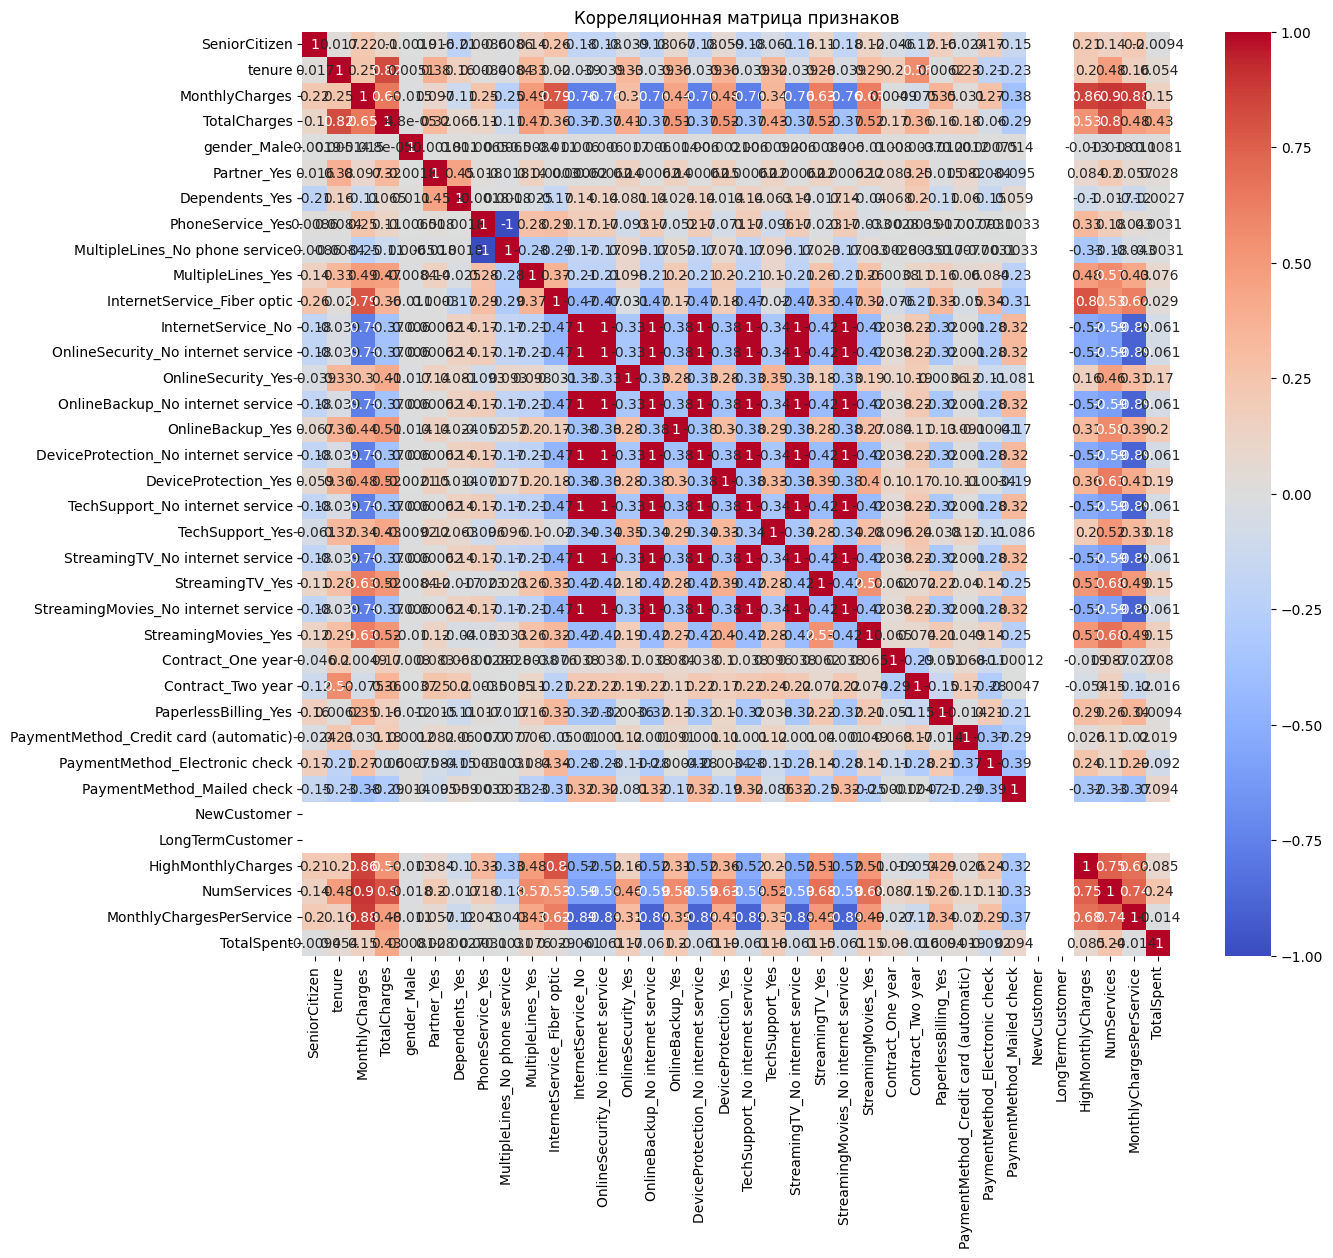

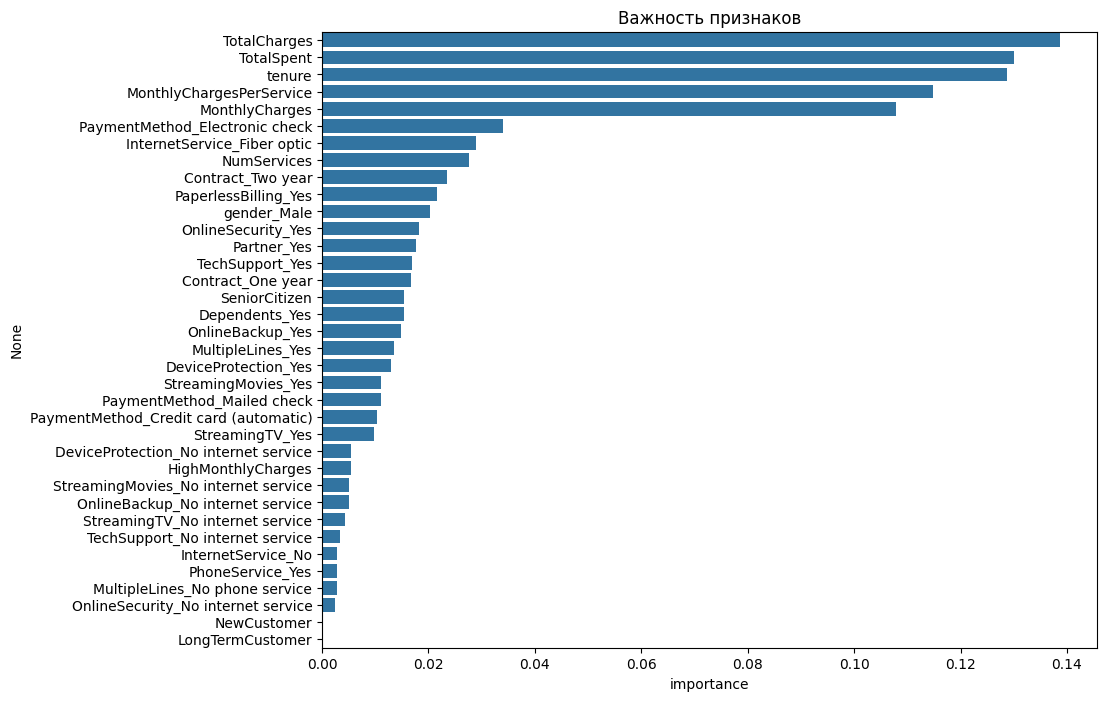

KeyError: "None of [Index(['TotalCharges', 'TotalSpent', 'tenure', 'MonthlyChargesPerService',\n       'MonthlyCharges', 'PaymentMethod_Electronic check',\n       'InternetService_Fiber optic', 'NumServices', 'Contract_Two year',\n       'PaperlessBilling_Yes', 'gender_Male', 'OnlineSecurity_Yes',\n       'Partner_Yes', 'TechSupport_Yes', 'Contract_One year', 'SeniorCitizen',\n       'Dependents_Yes', 'OnlineBackup_Yes', 'MultipleLines_Yes',\n       'DeviceProtection_Yes', 'StreamingMovies_Yes',\n       'PaymentMethod_Mailed check', 'PaymentMethod_Credit card (automatic)'],\n      dtype='object')] are in the [columns]"

In [12]:
# Отбор признаков (Feature selection)

# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

# Предположим, что данные уже загружены и предобработаны в DataFrame `df`

# Целевая переменная
target = 'Churn'

# Разделение данных на обучающую и тестовую выборки
X = df.drop(columns=[target, 'customerID'])  # Исключаем целевую переменную и идентификатор клиента
y = df[target].apply(lambda x: 1 if x == 'Yes' else 0)  # Преобразуем целевую переменную в числовой формат

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Корреляционная матрица
plt.figure(figsize=(14, 12))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

# Удаление признаков с высокой корреляцией
threshold = 0.8
high_corr_features = [column for column in corr_matrix.columns if any(abs(corr_matrix[column]) > threshold) and column != 'Churn']
X = X.drop(columns=high_corr_features)

# 2. Оценка важности признаков с помощью модели Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Получение важности признаков
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Отображение важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Важность признаков')
plt.show()

# Выбор наиболее важных признаков
selected_features = feature_importances[feature_importances['importance'] > 0.01].index.tolist()
X = X[selected_features]

# Вывод выбранных признаков
print("Выбранные признаки:", selected_features)
